# ECG Denoising

> We believe we can produce a more robust ECG classifier by learning representations of noisy ECG signals

In [20]:
from pathlib import Path

import numpy as np
import numpy.typing as npt
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.utils import resample

import os
os.environ["KERAS_BACKEND"] = "torch"

from ecg_classification.preprocessing import SyntheticNoise, preprocess_ecg_signals
from ecg_classification.models import CDAE
from ecg_classification.visualize import plot_ecg, plot_multiple_ecg
from ecg_classification.training import make_ecg_data_train_test_split, print_split_summary, randomly_oversample_minority_class, DataSplit

In [21]:
train, test = make_ecg_data_train_test_split(np.load(Path("../data/icentia11k/data.npz")), test_size=0.3, random_state=42)
print_split_summary(train)
print()
print_split_summary(test)

train split (31440, 800)
3525/31440 (0.1121) abnormal beats
34/31440 (0.0011) abnormal rhythms
Patients (n=21): [  900  9000  9154  9176  9184  9185  9376  9428  9596  9634  9764  9772
  9894  9946  9974 10278 10498 10515 10674 10907 10951]

test split (15720, 800)
46/15720 (0.0029) abnormal beats
277/15720 (0.0176) abnormal rhythms
Patients (n=10): [ 1100  9001  9314  9440  9635  9909 10351 10413 10532 10988]


In [22]:
# Rebalance absolute number of classes
train = randomly_oversample_minority_class(train, 0.1, random_state=42)
print_split_summary(train)

train split (34602, 800)
3525/34602 (0.1019) abnormal beats
3196/34602 (0.0924) abnormal rhythms
Patients (n=21): [  900  9000  9154  9176  9184  9185  9376  9428  9596  9634  9764  9772
  9894  9946  9974 10278 10498 10515 10674 10907 10951]


In [23]:
# Then downsample normal, to reduce training costs for now
train = DataSplit("train", *resample(train.X, train.y_rhythm, train.y_beat, train.patient, n_samples=10_000, stratify=train.y_rhythm, random_state=42))
print_split_summary(train)

train split (10000, 800)
999/10000 (0.0999) abnormal beats
924/10000 (0.0924) abnormal rhythms
Patients (n=21): [  900  9000  9154  9176  9184  9185  9376  9428  9596  9634  9764  9772
  9894  9946  9974 10278 10498 10515 10674 10907 10951]


In [24]:
# Apply simple signal preprocessing - smoothing, detrending, normalizing
train.X = preprocess_ecg_signals(train.X)
train.X.shape

(10000, 800)

In [ ]:
# For exporting to Google Colab
np.savez_compressed("../data/icentia11k/train_X.npz", train_X=train.X)

## Types of Noise

Powerline Interfance

Baseline Wander

Muscle artifacts

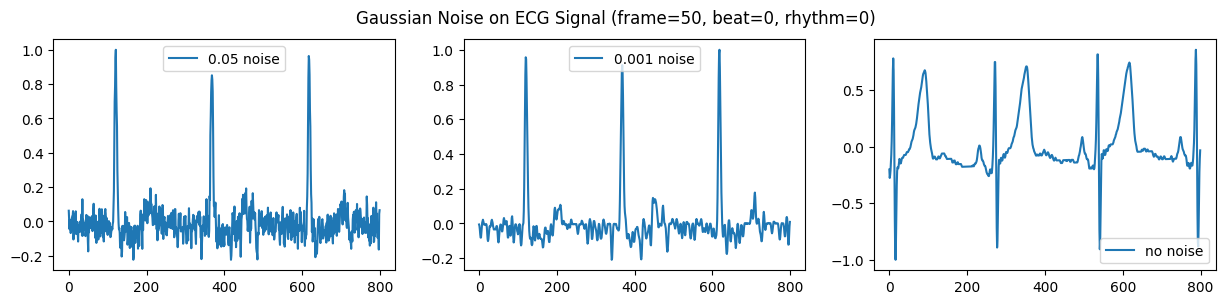

In [41]:
# Example gaussian noise applied to training example 0
syn_noise = SyntheticNoise(random_state=42)

frame = 50
fig, ax = plot_multiple_ecg([
    syn_noise.gaussian_noise(train.X[frame].reshape(1, -1), stddev=0.05)[0],
    syn_noise.gaussian_noise(train.X[frame].reshape(1, -1), stddev=0.001)[0],
    train.X[0]
], labels=["0.05 noise", "0.001 noise", "no noise"], layout="hstack")
fig.suptitle(f"Gaussian Noise on ECG Signal ({frame=}, beat={train.y_beat[frame]}, rhythm={train.y_rhythm[frame]})")
plt.legend();

## CDAE

Convolutional Denoising Autoencoder (CDAE) is models noisy ECG signals by learning to recover a clean ECG signal from a noisified version.

The original paper (Soto & Ashley 2020) that we base our multi-task model architecture on demonstrated good classification performance when the transfered the learned representation of ECG from CDAE to their main model.

In [26]:
cdae = CDAE(input_size=800, models_path=Path("../models"))
cdae.model.summary()

/home/ubungu/projects/ECG_Classification/.venv/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 30 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 800, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 800, 64)        │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 266, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 266, 45)        │        23,085 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 88, 45)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 88, 50)         │        11,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 44, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 44, 50)         │        12,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d (UpSampling1D)    │ (None, 88, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 88, 45)         │        18,045 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_1 (UpSampling1D)  │ (None, 264, 45)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 264, 64)        │        28,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_2 (UpSampling1D)  │ (None, 792, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50688)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 800)            │    40,551,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 800, 1)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,937,246 (465.15 MB)

 Trainable params: 40,645,748 (155.05 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 81,291,498 (310.10 MB)

In [27]:
from keras import callbacks

## Training

For this unsupervised learning task, we are not too concerned with grouping or stratifying by patient

In [63]:
def prep_noisy_dataset(X: npt.NDArray, noise_levels: npt.NDArray, samples_per_level: int) -> npt.NDArray:
    """Creates a dataset of noisy and original signals for use in training a CDAE
    
    Args:
        X: original raw signals, each row is an ECG signal
        noise_levels: levels of noise to apply
        samples_per_level: number of examples per noise level to create
    """
    noise_levels = np.repeat(noise_levels, samples_per_level, axis=0)

    X_noisy = []
    y = []
    for lvl in noise_levels:
        X_noisy.append(syn_noise.gaussian_noise(X, lvl))
        y.append(X)
    X_noisy = np.concatenate(X_noisy, axis=0)
    y = np.concatenate(y, axis=0)
    return X_noisy, y

X_noisy, y = prep_noisy_dataset(train.X, np.array([0.05, 0.1, 0.2, 0.3]), samples_per_level=1)
X_noisy.shape, y.shape

((40000, 800), (40000, 800))

In [64]:
from sklearn.model_selection import train_test_split

In [65]:
noisy_X_train, noisy_X_val, noisy_y_train, noisy_y_val = train_test_split(X_noisy, y, test_size=0.2, shuffle=True, random_state=42)
noisy_X_train.shape, noisy_y_train.shape, noisy_X_val.shape, noisy_y_val.shape

((32000, 800), (32000, 800), (8000, 800), (8000, 800))

(<Figure size 1500x300 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

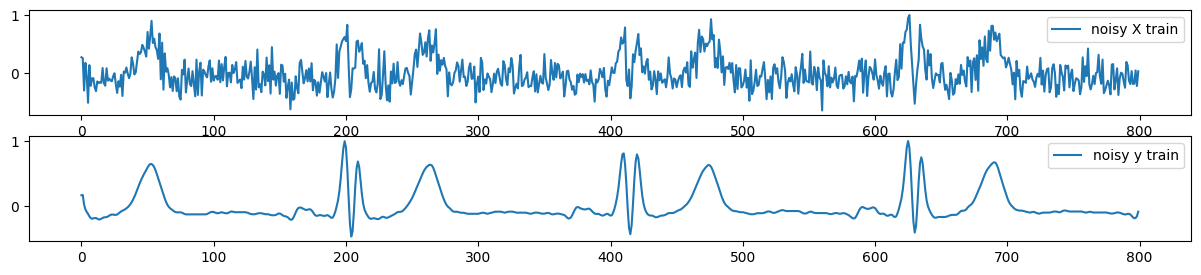

In [66]:
# Just checking that inputs make sense
frame = 10
plot_multiple_ecg([
    noisy_X_train[frame],
    noisy_y_train[frame]
], labels=["noisy X train", "noisy y train"])

In [67]:
# # Initial learning rate
# initial_lr = 0.01

def lr_schedule(epoch: int, lr: float) -> float:
    if epoch % 25 == 0 and epoch > 0:
        # Make sure the learning rate does not become negative
        return max(lr - 0.001, 0.0001)
    return lr

lr_reduction = callbacks.LearningRateScheduler(lr_schedule, verbose=1)

# Train Autoencoder
history = cdae.model.fit(
    # The input to the CDAE was the simulated signal dataset
    # with a Gaussian noise factor of 0.001, 0.5, 0.25, 0.75,
    # 1, 2, and 5 added to corrupt the simulated signals.
    x=noisy_X_train[:, :, np.newaxis],

    # The uncorrupted simulated signals are then used as the
    # target for reconstruction.
    y=noisy_y_train[:, :, np.newaxis],
    epochs=3,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_X_val[:, :, np.newaxis], noisy_y_val[:, :, np.newaxis]),
    # callbacks=[lr_reduction]
)

print(history.history)

Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 269s 1s/step - loss: 0.0462 - val_loss: 0.0406
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 218s 870ms/step - loss: 0.0403 - val_loss: 0.0406
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 256s 1s/step - loss: 0.0403 - val_loss: 0.0406
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 285s 1s/step - loss: 0.0404 - val_loss: 0.0406
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 265s 1s/step - loss: 0.0402 - val_loss: 0.0406
{'loss': [0.041379936039447784, 0.04037395864725113, 0.040373966097831726, 0.04037395119667053, 0.04037395492196083], 'val_loss': [0.040588781237602234, 0.040588781237602234, 0.040588781237602234, 0.040588781237602234, 0.040588781237602234]}


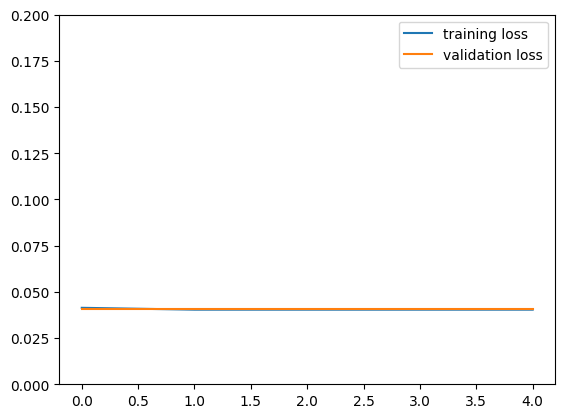

In [68]:
fig, ax = plt.subplots(1, 1)
ax.plot(np.arange(len(history.history["loss"])), history.history["loss"], label="training loss")
ax.plot(np.arange(len(history.history["val_loss"])), history.history["val_loss"], label="validation loss")
ax.set_ylim([0., 0.2])
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


(<Figure size 1500x300 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

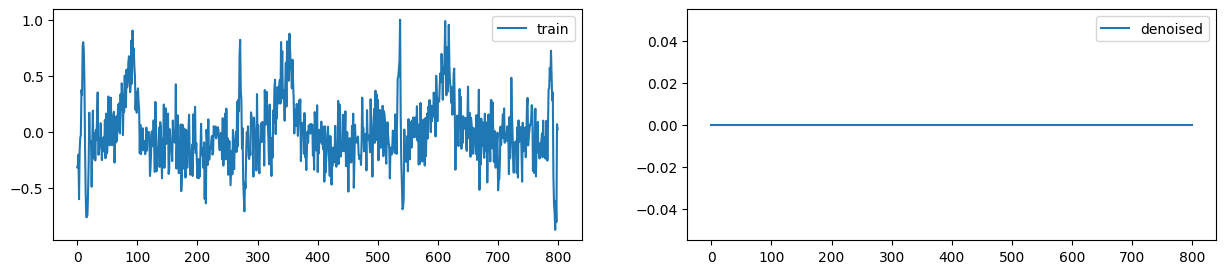

In [69]:
frame = 0
example = syn_noise.gaussian_noise(train.X, 0.2)[0]

plot_multiple_ecg([
    example,
    cdae.model.predict(example[np.newaxis, :, np.newaxis])[0, :, 0]
], labels=["train", "denoised"], layout="hstack")